In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import roc_auc_score

Загрузим данные

In [3]:
trades = pd.read_csv("quant_accuracy_t_2030.csv.gz")
trades.head()

,time,side,price,amount
0,1600992000070695,0,218950,773
1,1600992000070695,0,218950,1000
2,1600992000072200,0,218955,2012
3,1600992000072200,0,218970,40
4,1600992000072200,0,218970,14


In [4]:
# считаем что классы сбалансированы
trades['side'].value_counts()

0    3123937
1    3093944
Name: side, dtype: int64

In [5]:
trades.describe()

,time,side,price,amount
count,6.217881e+06,6.217881e+06,6.217881e+06,6.217881e+06
mean,1.601172e+15,4.975882e-01,2.248021e+05,1.034219e+03
std,7.950094e+10,4.999942e-01,4.127148e+04,3.725600e+03
min,1.600992e+15,0.000000e+00,1.585000e+05,1.000000e+00
25%,1.601125e+15,0.000000e+00,1.851200e+05,2.400000e+01
50%,1.601186e+15,0.000000e+00,2.261300e+05,1.770000e+02
75%,1.601220e+15,1.000000e+00,2.649450e+05,8.130000e+02
max,1.601333e+15,1.000000e+00,3.179500e+05,1.114967e+06


In [6]:
trades.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6217881 entries, 0 to 6217880
Data columns (total 4 columns):
 #   Column  Dtype
---  ------  -----
 0   time    int64
 1   side    int64
 2   price   int64
 3   amount  int64
dtypes: int64(4)
memory usage: 189.8 MB


Посмотрим на данные

<AxesSubplot:xlabel='amount', ylabel='Count'>

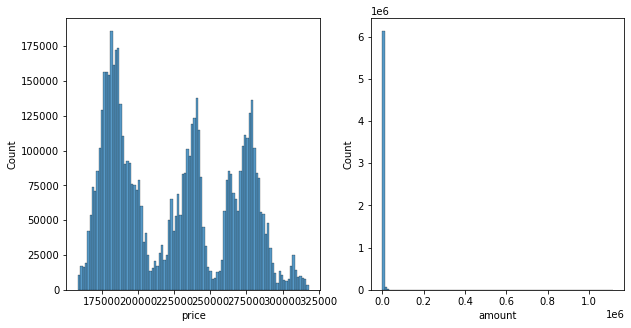

In [7]:
fig, ax =plt.subplots(1,2,figsize=(10,5))
sns.histplot(trades.price, ax=ax[0], bins=100)
sns.histplot(trades.amount, ax=ax[1], bins=100)

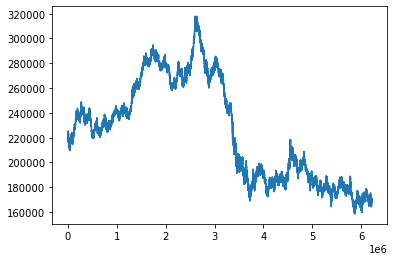

In [8]:
plt.plot(trades['price'])


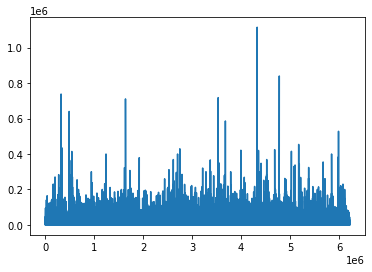

In [9]:
plt.plot(trades['amount'])

Сами значения цены не инетерсны, перейдем к разницам -1

In [10]:
trades['price_diff']=trades['price'].diff()
trades=trades.dropna()

Добавим новые признаки

In [11]:
trades['am*price']=trades['price']*trades['amount']

In [12]:
trades['diff_am*price']=trades['am*price'].diff()
trades=trades.dropna()

In [13]:
trades['amount_diff']=trades['amount'].diff()
trades=trades.dropna()

In [14]:
trades['diff_am*price']=trades['diff_am*price'].astype(float)
trades['am*price']=trades['am*price'].astype(float)
trades['amount_diff']=trades['amount_diff'].astype(float)
trades['side']=trades['side'].astype(float)

In [15]:
trades.head()

,time,side,price,amount,price_diff,am*price,diff_am*price,amount_diff
3,1600992000072200,0.0,218970,40,15.0,8758800.0,-431778660.0,-1972.0
4,1600992000072200,0.0,218970,14,0.0,3065580.0,-5693220.0,-26.0
5,1600992000072200,0.0,218990,419,20.0,91756810.0,88691230.0,405.0
6,1600992000073816,0.0,218990,628,0.0,137525720.0,45768910.0,209.0
7,1600992000073816,0.0,218995,56,5.0,12263720.0,-125262000.0,-572.0


In [27]:
period=32 # 30-892, 32-895
df=pd.DataFrame(columns=range(period+2))
z=[]
for i in range(10000): #10000
    z=list(trades.iloc[i:i+period,2])
    z.append(trades.iloc[i:i+period,3].sum())
    z.append(trades.iloc[period+i-1,1])
    df.loc[i]=z
    

In [17]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,218970.0,218970.0,218990.0,218990.0,218995.0,219000.0,219000.0,219035.0,219050.0,219050.0,...,219145.0,219010.0,219005.0,218995.0,218995.0,218980.0,218980.0,218980.0,34217.0,1.0
1,218970.0,218990.0,218990.0,218995.0,219000.0,219000.0,219035.0,219050.0,219050.0,219065.0,...,219010.0,219005.0,218995.0,218995.0,218980.0,218980.0,218980.0,218980.0,34180.0,1.0
2,218990.0,218990.0,218995.0,219000.0,219000.0,219035.0,219050.0,219050.0,219065.0,219070.0,...,219005.0,218995.0,218995.0,218980.0,218980.0,218980.0,218980.0,218955.0,35266.0,1.0
3,218990.0,218995.0,219000.0,219000.0,219035.0,219050.0,219050.0,219065.0,219070.0,219075.0,...,218995.0,218995.0,218980.0,218980.0,218980.0,218980.0,218955.0,218955.0,35478.0,1.0
4,218995.0,219000.0,219000.0,219035.0,219050.0,219050.0,219065.0,219070.0,219075.0,219090.0,...,218995.0,218980.0,218980.0,218980.0,218980.0,218955.0,218955.0,218955.0,35150.0,1.0


In [43]:
from sklearn.model_selection import train_test_split
X=df.iloc[:,:-1]
y=df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=42)

In [44]:

clf = ExtraTreesClassifier(n_estimators=1200, max_depth=None, min_samples_split=2, random_state=0, criterion='entropy')
clf.fit(X_train, y_train)
pred=clf.predict(X_test)
accuracy = clf.score(X_test, y_test)
print(f"accuracy = {accuracy:.3f}. Wow! Such accurate! Very model")
roc_auc_score(y_test, pred) #clf.predict(X_test))


accuracy = 0.906. Wow! Such accurate! Very model


0.9007358412567176